In [43]:
from qiskit import QuantumCircuit, transpile
import numpy as np

num_qubits = 8
qc = QuantumCircuit(num_qubits)
num_layers = int(np.ceil(np.log2(num_qubits)))


In [44]:
from qcc.ml import USE_CUDA

USE_CUDA


False

In [45]:
from itertools import zip_longest, tee

def convolve(wires):
    qc.rz(0.1, wires[0])
    qc.sx(wires[0])
    qc.rz(0.1, wires[0])
    qc.sx(wires[0])
    qc.rz(0.1, wires[0])
    
    qc.rz(0.1, wires[1])
    qc.sx(wires[1])
    qc.rz(0.1, wires[1])
    qc.sx(wires[1])
    qc.rz(0.1, wires[1])
    
    qc.cnot(wires[0], wires[1])
    qc.ry(0.1, wires[0])
    qc.rz(0.1, wires[1])
    qc.cnot(wires[1], wires[0])
    qc.ry(0.1, wires[0])
    qc.cnot(wires[0], wires[1])
    
    qc.rz(0.1, wires[0])
    qc.sx(wires[0])
    qc.rz(0.1, wires[0])
    qc.sx(wires[0])
    qc.rz(0.1, wires[0])
    
    qc.rz(0.1, wires[1])
    qc.sx(wires[1])
    qc.rz(0.1, wires[1])
    qc.sx(wires[1])
    qc.rz(0.1, wires[1])
        
def pool(wires):
    qc.crz(0.1, wires[0], wires[1])
    qc.x(wires[0])
    qc.crx(0.1, wires[0], wires[1])

def _convolution(iterable):
    a, b = tee(iterable)
    first = next(b, None)
    lst = list(zip_longest(a, b, fillvalue=first))
    last = lst.pop()[::-1]
    lst = lst[::2] + lst[1::2]

    if len(lst) > 1:
        lst.insert(0, last)

    for wires in lst:
        convolve(wires)

def _pooling(iterable):
    measurements = iterable[1::2]
    controlled = iterable[0::2]

    for wires in zip(measurements, controlled):
        pool(wires)

    return controlled

wires = qc.qubits
for _ in range(num_layers):
    _convolution(wires)
    wires = _pooling(wires)


/var/folders/sy/jspx4wmd7sd9lqc7clfzx4jw0000gn/T/ipykernel_84648/1672648257.py:16: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(wires[0], wires[1])
/var/folders/sy/jspx4wmd7sd9lqc7clfzx4jw0000gn/T/ipykernel_84648/1672648257.py:19: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(wires[1], wires[0])
/var/folders/sy/jspx4wmd7sd9lqc7clfzx4jw0000gn/T/ipykernel_84648/1672648257.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct

In [46]:
qc.draw('mpl')


KeyboardInterrupt: 

In [ ]:
qc = transpile(qc, basis_gates=["cx", "sx", "x", "ry", "rx", "rz"], optimization_level=0)
qc.depth(), sum(qc.count_ops().values())


(135, 415)

In [ ]:
135, 415
188, 593


(188, 593)

In [ ]:
qc = QuantumCircuit(num_qubits)

def _ry_pool(iterable):
    measurements = iterable[1::2]
    controlled = iterable[0::2]

    for wires in zip(measurements, controlled):
        qc.cry(0.1, wires[0], wires[1])

    return controlled

wires = qc.qubits
for _ in range(num_layers):
    wires = _ry_pool(wires)
    
qc = transpile(qc, basis_gates=["cx", "sx", "x", "ry", "rx", "rz"], optimization_level=0)
qc.depth(), sum(qc.count_ops().values())


(12, 28)

In [ ]:
from pathlib import Path

path = Path("/Users/mingyoungjeng/Documents/Spring 2023.nosync/quantum-convolutional-classifier/test/tmp")
for file in path.glob("**/mqcc*/*.*"):
    stem = file.stem.replace("mqcc_", "mqcc-optimized_")
    # items = file.stem.split("_")
    # items.insert(2, "16x16")
    # stem = "_".join(items)
    
    # items = file.parent.stem.split("_")
    # items.insert(2, "16x16")
    # parent = "_".join(items)
    
    new_path = file.parent.with_stem(file.parent.stem.replace("mqcc", "mqcc_optimized"))
    new_path.mkdir(parents=True, exist_ok=True)
    
    new_path = new_path / f"{stem}{file.suffix}"
    file.rename(new_path)


In [ ]:
from pathlib import Path

path = Path("/Users/mingyoungjeng/Downloads/results_thesis/_raw_results/CIFAR10")
dest = path / "32x32"

for file in path.glob("**/*_32x32_*.*"):
    parent = dest / file.parent.stem
    parent.mkdir(parents=True, exist_ok=True)
    
    new_path = parent / file.name
    file.rename(new_path)


In [ ]:
import numpy as np

test = np.array([[[0, 1], [2, 3]], [[4, 5], [6, 7]]])
print(test)

test.reshape(4, 2)


[[[0 1]
  [2 3]]

 [[4 5]
  [6 7]]]


array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [ ]:
from pathlib import Path
from PIL import Image

filename = Path("../img/color/Jayhawk_512x512x3.jpg")

with Image.open(filename, "r") as im:
    im.crop((0  , 0  , 256, 256)).save("tl.png")
    im.crop((128, 0  , 384, 256)).save("tc.png")
    im.crop((256, 0  , 512, 256)).save("tr.png")
    
    im.crop((0  , 128, 256, 384)).save("cl.png")
    im.crop((128, 128, 384, 384)).save("cc.png")
    im.crop((256, 128, 512, 384)).save("cr.png")
    
    im.crop((0  , 256, 256, 512)).save("bl.png")
    im.crop((128, 256, 384, 512)).save("bc.png")
    im.crop((256, 256, 511, 512)).save("br.png")


KeyboardInterrupt: 

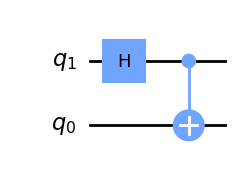

In [ ]:
from qiskit import QuantumCircuit


qc = QuantumCircuit(2)

qc.h(1)
qc.cx(1, 0)

qc.draw('mpl',reverse_bits=True)


In [ ]:
from pathlib import Path
from qcc.cli.pooling import _pooling

inputs = Path("/Users/mingyoungjeng/Documents/Spring 2023.nosync/quantum-convolutional-classifier/img/color")

for n in [False]:
    for method in ["none"]:
            _pooling(method, [0], inputs=inputs, output_dir=Path("results"), noiseless=n)


In [ ]:
from pathlib import Path

path = Path("/Users/mingyoungjeng/Downloads/pooling_results/results_pooling_1000000")
for file in path.glob("**/*_noisy.png"):
    stem = file.stem.replace("_noisy", "_100000")

    # parent = dest / file.parent.stem
    # parent.mkdir(parents=True, exist_ok=True)
    
    # new_path = parent / file.name
    file.rename(file.with_stem(stem))


In [ ]:
from pathlib import Path

root = Path("/Users/mingyoungjeng/Downloads/results_pooling")
path = Path("/Users/mingyoungjeng/Downloads/pooling_results")
for file in path.glob("**/*.png"):
    parent = file.parent.stem
    
    stem = file.stem.split("_")
    parent1, parent2, stem = stem[0], stem[-1], [parent, *stem[1:-1]]
    stem = "_".join(stem)
    
    parent = root / parent1 / parent2
    parent.mkdir(parents=True, exist_ok=True)
    
    new_path = parent / f"{stem}.png"
    # print(new_path)
    file.rename(new_path)


In [ ]:
import polars as pl

x = "noiseless"
 
# read DataFrame
df = pl.read_csv(f"/Users/mingyoungjeng/Downloads/results_pooling/results_{x}.csv")


 
for data_size, group in df.group_by(['data_size']):
    group = group.select("dimension_reduction","fidelity")
    group.write_csv(f'{x}_{data_size[0]}.csv')
 
# print(pd.read_csv("Male.csv"))
# print(pd.read_csv("Female.csv"))


FileNotFoundError: No such file or directory (os error 2): /Users/mingyoungjeng/Downloads/results_pooling/results_noiseless.csv

In [345]:
from qcc.quantum import to_qubits
import torch

def get_params(x_in: np.ndarray | torch.Tensor):
    p = x_in
    num_qubits = to_qubits(len(x_in))
    for i in range(num_qubits):
        x = p.reshape((len(p) // 2, 2))
        p = x.norm(dim=1) if hasattr(x, "norm") else np.linalg.norm(x, axis=1)
        
        x = (x / (p[:, None]+1e-12)).T
        
        # ==== Ry angles ==== #
        mag = abs(x)
        theta = mag[0] + mag[1]*1j
        theta = theta.angle() if hasattr(theta, "angle") else np.angle(theta)
        theta = 2*theta
        
        # ==== Rz angles ==== #
        if i == 0:
            phase = x.angle() if hasattr(x, "angle") else np.angle(x)
            phi = phase[1] - phase[0]
            t = phase[1] + phase[0]


In [346]:
import torch

x_in = np.array([1, 0, 0, 0])
get_params(x_in)

print("===========================")

x_in = torch.tensor(x_in, dtype=torch.complex128, requires_grad=True)
get_params(x_in)

False
True


In [335]:
def get_params(x_in):
    p = x_in
    while len(p) > 1:
        x = np.reshape(p, (int(len(p) / 2), 2))
        p = np.linalg.norm(x, axis=1)

        with np.errstate(divide="ignore", invalid="ignore"):
            alpha, beta = np.array([y / m if m > 0 else (1, 0) for y, m in zip(x, p)]).T

            alpha_mag, beta_mag = np.abs((alpha, beta))
            alpha_phase, beta_phase = np.angle((alpha, beta))

            with np.errstate(divide="ignore"):
                theta = 2 * np.arctan(beta_mag / alpha_mag)
            phi = beta_phase - alpha_phase
            r = np.sqrt(alpha_mag**2 + beta_mag**2)
            t = beta_phase + alpha_phase

        print(theta, phi, r, t)
        
x_in = np.array([1, 0, 0, 0])
get_params(x_in)

[0. 0.] [0. 0.] [1. 1.] [0. 0.]
[0.] [0.] [1.] [0.]


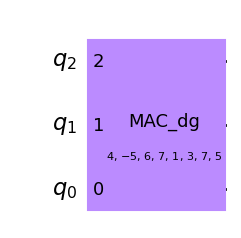

In [5]:
from qcc.quantum.qiskit.c2q import C2Q
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

qc = QuantumCircuit(3)
x_in = np.array([4, -5, 6, 7, 1, 3, 7, 5])
n = np.linalg.norm(x_in)

test = C2Q(x_in)
qc.compose(test, inplace=True)

qc.decompose().draw("mpl", reverse_bits=True)

In [2]:
n * Statevector(qc).data.round(4)

array([ 3.99961998+0.j, -4.99952498-0.j,  5.99942997+0.j,  6.99933497+0.j,
        0.999905  +0.j,  2.99971499+0.j,  6.99933497+0.j,  4.99952498+0.j])

/Users/mingyoungjeng/Documents/repos.nosync/quantum-convolutional-classifier/.env/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


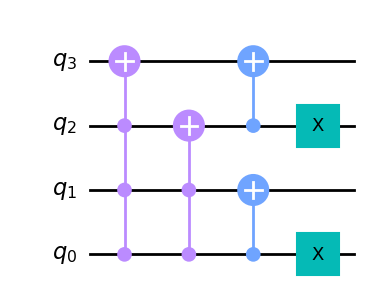

In [1]:
from qcc.quantum.qiskit import Shift
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

qc = QuantumCircuit(4)
test = Shift(4, k=5)
qc.compose(test, inplace=True)

qc.decompose().draw("mpl", reverse_bits=True)